<a href="https://www.kaggle.com/code/angelchaudhary/precision-recall-vs-roc-in-imbalanced-data?scriptVersionId=292486747" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Precision–Recall vs ROC Curves: Evaluating Classification Models on Imbalanced Datasets

# Introduction

In many real-world classification problems—such as fraud detection, medical diagnosis, or anomaly detection, the dataset is highly imbalanced, where one class (usually the positive class) occurs far less frequently than the other. Traditional evaluation metrics like accuracy and even ROC-AUC can be misleading in such scenarios, as they may present an overly optimistic view of model performance while failing to capture how well the model identifies the minority class.

While **ROC curves** are widely used and well-understood, they do not always provide meaningful insights when dealing with imbalanced datasets. In contrast, **Precision–Recall (PR) curves** focus directly on the performance of the minority (positive) class, making them more informative in these cases.  
This notebook aims to clarify:
- Why ROC-AUC can be deceptive for imbalanced data
- When and why Precision Recall curves should be preferred
- How both metrics behave differently under class imbalance

## Approach
In this notebook, we will:
1. Work with an imbalanced classification dataset
2. Train a binary classification model
3. Evaluate the model using both ROC curves and Precision–Recall curves
4. Compare their interpretations and numerical scores
5. Draw practical conclusions on metric selection for imbalanced problems

# LET'S DO IT!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExaHllZnoxZnAxYTI2aXFqeGJleXBrbTY4ZXFuMDNpcm0xeHU3bmdpeCZlcD12MV9zdGlja2Vyc19zZWFyY2gmY3Q9cw/hiJ9ypGI5tIKdwKoK2/giphy.gif)

## Dataset Overview

This notebook uses the Credit Card Fraud Detection dataset, which contains 284,807 real credit card transactions made by European cardholders over two days in September 2013. Only 492 transactions are fraudulent, resulting in an extreme class imbalance of approximately 0.172%. The dataset consists of 30 numerical features, where V1–V28 are anonymized features obtained through PCA, along with `Time` and `Amount`, and the target variable `Class` indicates whether a transaction is fraudulent (1) or legitimate (0). Due to the severe imbalance, this dataset is well-suited for analyzing the limitations of ROC curves and highlighting the importance of Precision–Recall–based evaluation metrics.

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/creditcardfraud


In [2]:
import pandas as pd
import numpy as np 
df = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")

In [3]:
df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
df['Class'].value_counts(), df['Class'].value_counts(normalize=True)

(Class
 0    284315
 1       492
 Name: count, dtype: int64,
 Class
 0    0.998273
 1    0.001727
 Name: proportion, dtype: float64)

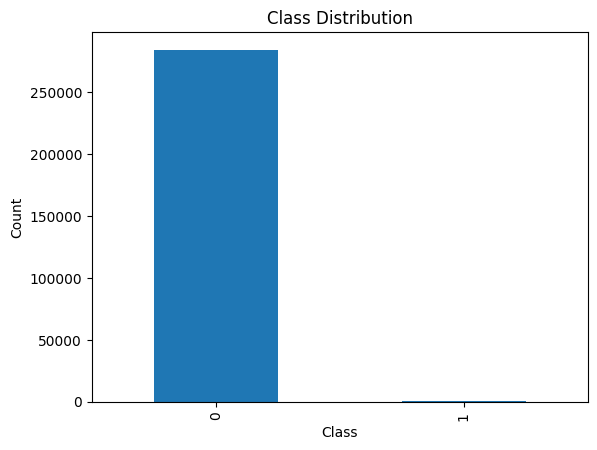

In [7]:
import matplotlib.pyplot as plt

df['Class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### Observation: Class Imbalance
The dataset exhibits extreme class imbalance, with legitimate transactions accounting for approximately **99.83%** of the data, while fraudulent transactions make up only **0.17%**. This imbalance implies that a model can achieve very high accuracy by simply predicting all transactions as non-fraudulent, while completely failing to detect actual fraud cases. As a result, accuracy-based evaluation and even ROC curves can be misleading, motivating the need for Precision–Recall–based evaluation metrics.

## Train-Test Split + Baseline Model

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=2000, random_state=42))
])

pipeline.fit(X_train, y_train)

y_prob = pipeline.predict_proba(X_test)[:, 1]


## ROC Curve Analysis

The Receiver Operating Characteristic (ROC) curve evaluates the trade-off between the True Positive Rate (Recall) and the False Positive Rate across different classification thresholds. ROC-AUC is commonly used to measure the overall discriminative ability of a classifier. However, in highly imbalanced datasets, ROC curves can present an overly optimistic view of model performance.

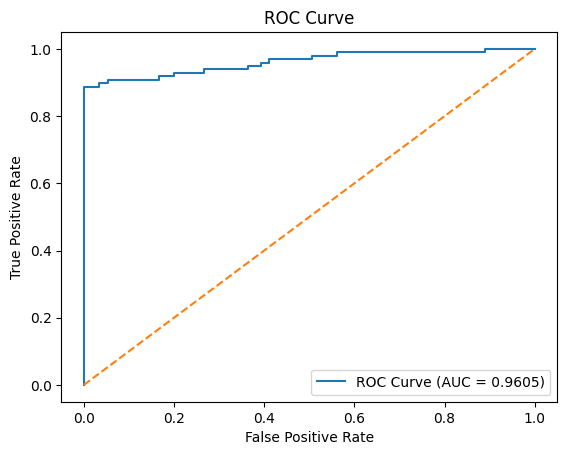

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Observation: ROC Curve

The ROC curve demonstrates a strong discriminative performance, with a high ROC-AUC score of **0.9605**, indicating that the model is able to separate fraudulent and legitimate transactions across a wide range of thresholds. However, in the presence of extreme class imbalance, this high ROC-AUC can be misleading. The metric is heavily influenced by the majority class, meaning a low False Positive Rate can be achieved even when the model detects only a small fraction of actual fraud cases.

## Precision–Recall Curve Analysis

The Precision–Recall (PR) curve focuses on the performance of a classifier on the positive (minority) class by analyzing the trade-off between precision and recall across different thresholds. Unlike ROC curves, Precision–Recall curves are more informative for highly imbalanced datasets, as they directly reflect the model’s ability to correctly identify rare positive instances.

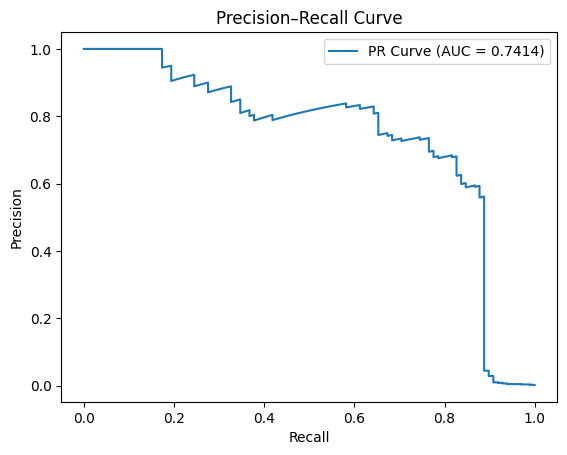

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

plt.figure()
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.show()

### Observation: Precision–Recall Curve

The Precision Recall curve provides a more realistic assessment of model performance on the minority class. Although the model achieves a moderate PR-AUC of **0.7414**, precision drops sharply as recall increases, indicating that detecting a larger proportion of fraudulent transactions comes at the cost of a significant increase in false positives. This behavior highlights the difficulty of fraud detection under extreme class imbalance and demonstrates why Precision–Recall curves are more informative than ROC curves in such scenarios.

## ROC vs Precision–Recall Comparison

The ROC curve suggests strong model performance with a high ROC-AUC score, while the Precision–Recall curve reveals the practical limitations of the classifier in identifying rare fraud cases. This discrepancy occurs because ROC-AUC is influenced by the majority class, whereas Precision–Recall metrics focus directly on minority-class performance. As a result, Precision–Recall curves provide more meaningful insights for evaluating models on highly imbalanced datasets.

## Conclusion

This analysis demonstrates that ROC-AUC alone is insufficient for evaluating classifiers on highly imbalanced datasets. While the ROC curve indicated strong overall discrimination, the Precision–Recall curve exposed the trade-off between recall and false positives when detecting rare fraud cases. Therefore, Precision–Recall–based evaluation should be preferred in imbalanced classification problems where correctly identifying the positive class is critical.